In [40]:
%matplotlib notebook
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import scipy.misc
import numpy as np
from PIL import Image
from six.moves import xrange

tag_dir = './tag/tag_hierarchy'
thumb_dir = './tag'
image_dir = './data'
image_size = 256

In [52]:
"""
absolutely no use...
# tag xml parser
ImageFeatures = {}
MainImageFeatures = {}
AllTags = {}
class tagdata:
    def __init__(self, path='', imagedir=''):
        # init
        self.xml = None
        self.name = ''
        self.path = path
        #self.ImagePath = ''
        #self.ResizeImagePath = ''
        self.ImageDir = imagedir
        self.ImageFeatures = []
        self.MainImageFeatures = []
        self.tags = []
        if path != '':
            self.load(path, imagedir)
    
    def load(self, path, imagedir):
        self.xml = ET.parse(path)
        root = self.xml.getroot()
        self.name = root.attrib['path'] + root.attrib['filename']
        #self.ImagePath = root.attrib['path'] + root.attrib['filename'] + '.png'
        #self.ImagePath = self.ImagePath.replace('./', '')
        self.ImagePath = os.path.join(imagedir, self.name)
        for tag in root.iter('tag'):
            self.tags.append(tag.text)
            if not tag.text in AllTags:
                AllTags[tag.text] = 1
            else:
                AllTags[tag.text] = AllTags[tag.text] + 1
        feature = None
        for feat in root.findall('primary_category'):
            if feat.attrib['name'] == 'Scattering features in image':
                feature = feat
                break
        if feature != None:
            for row_tag in feature.iter('row_tag'):
                mainfeat = row_tag.attrib['name']
                self.MainImageFeatures.append(mainfeat)
                if not mainfeat in MainImageFeatures:
                    MainImageFeatures[mainfeat] = 1
                else:
                    MainImageFeatures[mainfeat] = MainImageFeatures[mainfeat] + 1
            for tag in feature.iter('tag'):
                self.ImageFeatures.append(tag.text)
                if not tag.text in ImageFeatures:
                    ImageFeatures[tag.text] = 1
                else:
                    ImageFeatures[tag.text] = ImageFeatures[tag.text] + 1
"""
from tagio.tag import tagdata, AllTags, ImageFeatures, MainImageFeatures
print('Class tagdata is moved to package tagio.tag to support external access.')

Class tagdata is moved to package tagio.tag to support external access.


In [49]:
# load all the tag files in a directory
def fetch_tag_filelist(tag_dir):
    tag_list = []
    for root, dirs, files in os.walk(tag_dir):
        for name in files:
            filename, extname = os.path.splitext(name)
            if extname == '.tag':
                tag_list.append(os.path.join(root, name))
    return tag_list


# resize images and construct the image dictionary
def preprocess_image(tags, size, output_file, checkAvail=False):
    list_fail = []
    counter_success = 0
    output = {}
    for _, tag in tags.items():
        if not os.path.isfile(tag.ImagePath):
            list_fail.append(tag.ImagePath)
            continue
        #ResizeImagePath = os.path.join(pre_dir, tag.name + '.npy')
        #tag.ResizeImagePath = ResizeImagePath
        # generate a filelist only if checkAvail flag is toggled on
        if not checkAvail:
            #img = mpimg.imread(tag.ImagePath)
            # discard alpha channel
            #img = scipy.misc.imresize(img, (size, size))
            #np.save(ResizeImagePath, img)
            img = Image.open(tag.ImagePath)
            img = img.resize((size, size))
            output[tag.name] = img
        counter_success = counter_success + 1
    if not checkAvail:
        np.save(output_file, output)
    return counter_success, list_fail

In [50]:
tag_list = fetch_tag_filelist(tag_dir)
tags = {}
for tagfile in tag_list:
    #tag.append(tagdata(tagfile, './tag'))
    tag = tagdata(tagfile, image_dir)
    tags[tag.name] = tag

In [53]:
print('%d images, %d tags' % (len(data), len(tags)))
# note that the stats here are not accurate b/c not all tags have the corresponding image data
MainImageFeatures

2385 images, 2833 tags


{'Diffuse high-q': 386,
 'Diffuse low-q': 362,
 'Halo': 995,
 'Higher orders': 1172,
 'Peaks': 1409,
 'Ring': 1593,
 'Symmetry ring': 55}

In [30]:
# save tags and image data
np.save('./pre/tags.npy', tags)
n, f = preprocess_image(tags, image_size, './pre/data.npy', checkAvail=False)
n

2385

In [11]:
# load tags and image data
import dataset_loader as loader
import importlib

loader = importlib.reload(loader)
tags = np.atleast_1d(np.load('./pre/tags.npy'))[0]
data = np.atleast_1d(np.load('./pre/data.npy'))[0]
dataset = loader.read_data_sets(data, tags, 'Halo')
pos = [x for x in xrange(dataset.train._labels.shape[0]) if dataset.train._labels[x] == 1]
neg = [x for x in xrange(dataset.train._labels.shape[0]) if dataset.train._labels[x] == 0]
print('%d positive, %d negative' % (len(pos), len(neg)))

936 positive, 1449 negative


In [41]:
# visualize a few samples
from ipywidgets import interact
from IPython.core.display import display, HTML
%matplotlib inline


def browse_images(images, size, tags=None, names=''):
    n = images.shape[0]
    def view_image(i):
        #plt.imshow(np.resize(images[i,:], size), cmap=plt.cm.gray_r, interpolation='nearest')
        if tags:
            print(tags[i])
        plt.imshow(np.resize(images[i,:], size), interpolation='nearest')
        if isinstance(names, list):
            #plt.title(names[i])
            xmlpath = os.path.join(tag_dir, names[i] + '.tag')
            thumbpath = os.path.join(thumb_dir, names[i] + '.png')
            #print(xmlpath)
            display(HTML('<a href="' + 
                         xmlpath + '" target="_blank">tag</a>&nbsp;' +
                         '<a href ="' + 
                         thumbpath + '" target="_blank">thumb</a>'))
        else:
            plt.title('%s %d' % (names, i))
        plt.show()
    interact(view_image, i=(0,n-1))

['Diffuse low-q']


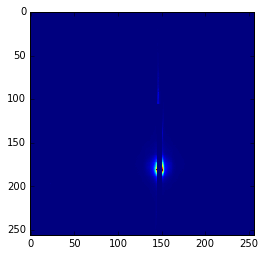

In [42]:
browse_images(dataset.train._images, (image_size, image_size), 
              tags=dataset.train._raw_labels, names=dataset.train._names)

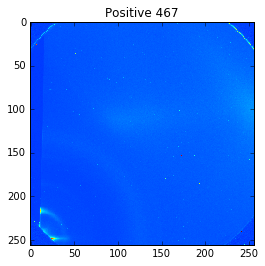

In [17]:
browse_images(dataset.train._images[pos,:], (image_size, image_size), names='Positive')

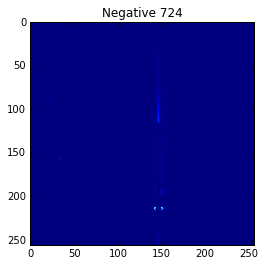

In [18]:
browse_images(dataset.train._images[neg,:], (image_size, image_size), names='Negative')